# 신용카드 이상탐지

ref : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# ==============================학습 ==============================
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.ensemble     import RandomForestClassifier
from sklearn.tree         import DecisionTreeClassifier
from sklearn.linear_model import Ridge, Lasso
from sklearn.impute       import SimpleImputer
# ---- 추가 모델
from sklearn.ensemble     import AdaBoostClassifier, VotingClassifier
from xgboost              import XGBClassifier
from lightgbm             import LGBMClassifier
from catboost             import CatBoostClassifier # -> 카테고리성에서 아주 좋은 성능

#============================== 평가 =============================
from sklearn.metrics import confusion_matrix # 오차행렬
from sklearn.metrics import classification_report # f1, 정밀도, 재현율
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, plot_roc_curve


# Data Load

In [3]:
df = pd.read_csv('./datasets/creditcard.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- V들은 개안정보들을 -> PCA 한 값 

# EDA

## Target feature : Class -> 불균형

In [4]:
print(df['Class'].value_counts())
print(f"1의 비율  : { (len( df[df['Class']==1]) / len(df)) *100} %")


0    284315
1       492
Name: Class, dtype: int64
1의 비율  : 0.1727485630620034 %


## 시각화

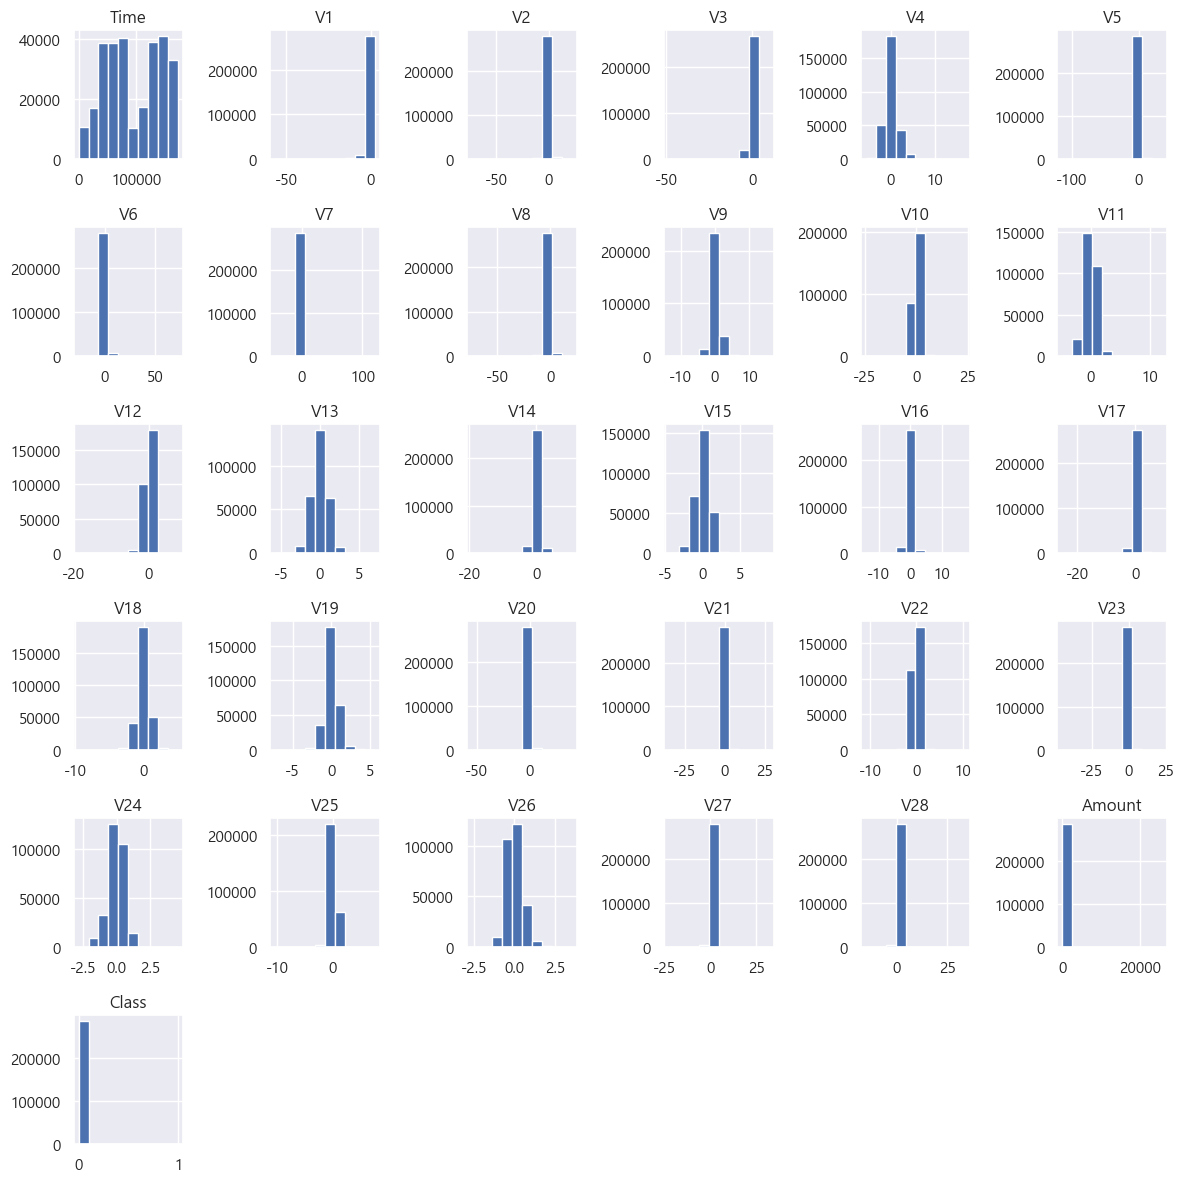

In [5]:
df.hist(figsize=(12,12))
plt.tight_layout()
plt.show()

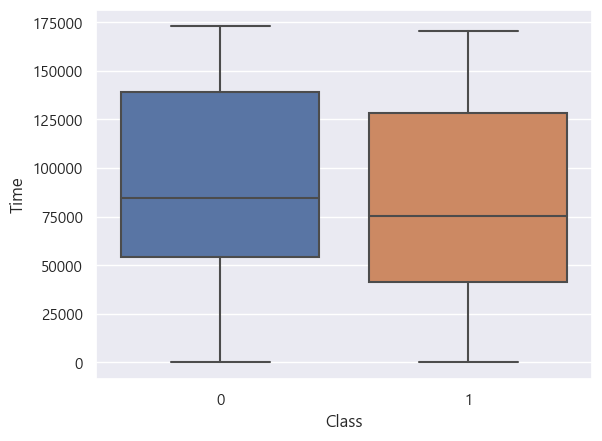

In [6]:
sns.boxplot(y = df['Time'], x = df['Class'])
plt.show()

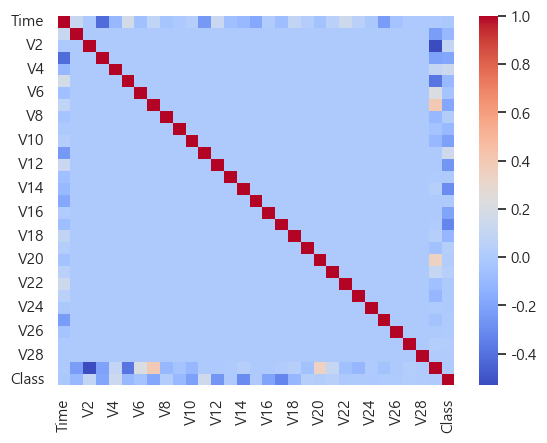

In [17]:
sns.heatmap(df.corr(),cmap='coolwarm')
plt.show()

In [ ]:
print(df.corr().nlargest(5,'Class').index.values) # ['Class' 'V11' 'V4' 'V2' 'V21']
print(df.corr().nsmallest(5,'Class').index.values) # ['V17' 'V14' 'V12' 'V10' 'V16']

In [ ]:
fig,ax = subplots(1,2)
sns.heatmap(df[['Class' ,'V11', 'V4', 'V2', 'V21']].corr(),annot=True,fmt='.2f',ax=ax[0])
sns.heatmap(df[['V17' ,'V14', 'V12' ,'V10', 'V16']].corr(),annot=True,fmt='.2f', ax= ax[0])
plt.show()

In [ ]:
# import pandas_profiling
# report = pandas_profiling.ProfileReport(df)
# report

# 학습 & 평가
<pre>
f1_score : 0.74713
정밀도 : 0.74713
재현율 : 0.74713
accuracy_score : 0.99923

In [10]:
X = df.drop('Class', axis = 1)
y = df['Class']
model = DecisionTreeClassifier(random_state=1)
X_train,X_test, y_train, y_test = train_test_split(X,y,random_state = 1,test_size=0.2)
model.fit(X_train,y_train)
pre=model.predict(X_test)
score=accuracy_score(y_test, pre)

print(f'f1_score : {f1_score(y_test,pre):.5}')
print(f'정밀도 : {precision_score(y_test,pre):.5}')
print(f'재현율 : {recall_score(y_test,pre):.5}')
print(f'accuracy_score : {score:.5}')

f1_score : 0.74713
정밀도 : 0.74713
재현율 : 0.74713
accuracy_score : 0.99923


In [ ]:
# print(classification_report(y_test,pre))

# 데이터 증강

- ref : https://casa-de-feel.tistory.com/15
- sampling 종류

## under sampling vs over sampling
- 일반적으로 over sampling을 사용 -> 주로 KNN사용

<img src = 'https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F2yuj6%2FbtqGirRpGhD%2FhmIPmKkQ6WMJ0PbpZZ5Wk0%2Fimg.png' width= '700'>

### Under Sampling
- 작은 데이터에 맞춘다
- 큰 데이터를 작게 
- 단점 : 정보손실

#### 방법1. df.sample() 이용 

In [9]:
len(df[df['Class']==1]) # 492

492

In [29]:
df0 = df[df['Class']==0].sample(n=492, random_state=111, ignore_index=True)
df1 = df[df['Class']==1]

print(df0.shape, df1.shape)
print( df0['Class'].value_counts())
print( df1['Class'].value_counts())

(492, 31) (492, 31)
0    492
Name: Class, dtype: int64
1    492
Name: Class, dtype: int64


In [44]:
df_under = pd.concat([df0,df1],ignore_index=True, axis=0)

print(df_under.shape)
print(df_under['Class'].value_counts())

(284807, 31)
0    284315
1       492
Name: Class, dtype: int64


In [45]:
df_under.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### 방법2. sklearn의 train_test_split() 이용

In [36]:
df0 = df[df['Class']==0]
df1 = df[df['Class']==1]

df0_other, df0_491 = train_test_split(df0, test_size = 491, random_state = 111)
print(len(df0_491))

dfdf = pd.concat([df1, df0_491], axis = 0 , ignore_index= True)
print(dfdf.shape)
print(dfdf['Class'].value_counts())

491
(983, 31)
1    492
0    491
Name: Class, dtype: int64


#### 방법3. sklearn의 RandomUnderSampler() 사용
- class imblearn.under_sampling.RandomUnderSampler(*, sampling_strategy='auto', random_state=None, replacement=False)

In [42]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
X_ = df.drop('Class',axis=1)
y_ = df['Class']

X_, y_ = RandomUnderSampler(random_state=111).fit_resample(X_, y_)
y_.value_counts()
idf = pd.concat([X_,y_],axis=1)

print(idf.shape)
idf.head(2)

(984, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,63153.0,-0.357434,1.509446,0.151077,1.261251,0.140974,-0.755096,0.738220,0.211872,-1.071702,-0.012199,0.019532,0.839610,1.096308,0.675065,0.864935,-0.977552,0.464042,-0.723566,0.181106,0.053622,0.264193,0.922810,0.142250,0.449895,-0.863967,-0.347555,0.394512,0.245552,20.0,0
1,130826.0,1.846300,0.364943,0.517735,3.975179,-0.480889,0.004586,-0.461989,0.030844,-0.422210,1.347603,-0.865177,0.428585,0.909862,-0.425782,-0.715392,1.027925,-0.813044,-0.214229,-1.905675,-0.250153,0.207528,0.772237,0.234159,0.460759,-0.260607,-0.002086,0.024106,-0.025635,0.0,0


### 언더샘플링(df_under) 후 학습& 평가

<pre>
f1_score : 0.76636
정밀도 : 0.75926
재현율 : 0.77358
accuracy_score : 0.99912

In [47]:
X = df_under.drop('Class', axis = 1)
y = df_under['Class']
model = DecisionTreeClassifier(random_state=1)
X_train,X_test, y_train, y_test = train_test_split(X,y,random_state = 1,test_size=0.2)
model.fit(X_train,y_train)
pre=model.predict(X_test)
score=accuracy_score(y_test, pre)

print(f'f1_score : {f1_score(y_test,pre):.5}')
print(f'정밀도 : {precision_score(y_test,pre):.5}')
print(f'재현율 : {recall_score(y_test,pre):.5}')
print(f'accuracy_score : {score:.5}')

f1_score : 0.76636
정밀도 : 0.75926
재현율 : 0.77358
accuracy_score : 0.99912


### Over Sampling
- 큰 데이터에 맞춘다
- 작은 데이터를 크게

#### sklearn의 SMOTE()
- class imblearn.over_sampling.SMOTE(*, sampling_strategy='auto', random_state=None, k_neighbors=5, n_jobs=None)[source]


In [50]:
import imblearn
from imblearn.over_sampling import SMOTE
X_ = df.drop('Class',axis=1)
y_ = df['Class']

X_, y_ = SMOTE(random_state=111).fit_resample(X_, y_)
y_.value_counts()
df_over = pd.concat([X_,y_],axis=1)

print(df_over.shape)
print(df_over['Class'].value_counts())
df_over.head(2)

(568630, 31)
0    284315
1    284315
Name: Class, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


### 오버샘플링(df_over) 후 학습& 평가

<pre>
f1_score : 0.99829
정밀도 : 0.99747
재현율 : 0.99912
accuracy_score : 0.99829

In [51]:
X = df_over.drop('Class', axis = 1)
y = df_over['Class']
model = DecisionTreeClassifier(random_state=1)
X_train,X_test, y_train, y_test = train_test_split(X,y,random_state = 1,test_size=0.2)
model.fit(X_train,y_train)
pre=model.predict(X_test)
score=accuracy_score(y_test, pre)

print(f'f1_score : {f1_score(y_test,pre):.5}')
print(f'정밀도 : {precision_score(y_test,pre):.5}')
print(f'재현율 : {recall_score(y_test,pre):.5}')
print(f'accuracy_score : {score:.5}')

f1_score : 0.99829
정밀도 : 0.99747
재현율 : 0.99912
accuracy_score : 0.99829
